# MP/BME 573: Homework Set 6 / Image recon

In [27]:
## MP 573 HW6 / Image reconstruction
##
%matplotlib inline
import numpy as np
import numpy.linalg as la
import matplotlib.pyplot as plt
from IPython.display import display, Image
import matplotlib.image as mpimg
from os.path import dirname, join as pjoin
from scipy import signal
import scipy.io as sio
import scipy.optimize as opt
import numpy.random as rnd
import scipy.sparse as sparse

font = {'weight' : 'normal',
        'size'   : 20}

In [28]:
# Fitting 1/2[|| Fx - d ||^2 + lambda ||Dx||^2]
# 1/2 || [F;sqrt(lambda)D]x - [d;0] ||^2
# This function returns the value and gradient of our cost function
# Note the 1/2 factor, to keep consistent with the CG notation presented in HW2
def evalGradients2(x,N,data,m,lam,D,w):
    
    N1 = N[0]
    N2 = N[1]
    
    wvec = np.reshape(w,(N1*N2,1))
    
    fx1 = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(np.reshape(x,(N1,N2)))))

    fx1 = np.reshape(fx1,(N1*N2,1))
    fx = fx1[np.reshape(m,(N1*N2))]
    
    f = 1/2*(la.norm(fx-data)**2 + lam*la.norm(wvec*(D.dot(np.reshape(x,(N1*N2,1)))))**2)
    
    fhfx = N1*N2*np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(np.reshape(m,(N1,N2))*np.reshape(fx1,(N1,N2)))))
    mhd = np.zeros((N1*N2,1),dtype='cfloat')
    mhd[np.reshape(m,(N1*N2))] = data    
    fhd = N1*N2*np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(np.reshape(mhd,(N1,N2)))))
    temp = wvec*wvec*(D.dot(np.reshape(x,(N1*N2,1))))
    g = np.reshape(fhfx,(N1*N2,1)) + lam*(D.T).dot(temp) - np.reshape(fhd,(N1*N2,1))
        
    return f,g


In [46]:
WHICH_PROBLEM = 2
data_dir = pjoin('.', 'data')
if WHICH_PROBLEM == 1:
    mat_fname = pjoin(data_dir, 'hw6_recon_problem1.mat')
    mat_contents = sio.loadmat(mat_fname)
    data = mat_contents['b']
    m = mat_contents['m']
    N1 = int(np.sqrt(m.size))
    N2 = N1
    w = np.ones((N1,N2))
    lam = 0
elif WHICH_PROBLEM == 2:
    mat_fname = pjoin(data_dir, 'hw6_recon_problem2.mat')
    mat_contents = sio.loadmat(mat_fname)
    data = mat_contents['b']
    m = mat_contents['m']
    N1 = int(np.sqrt(m.size))
    N2 = N1
    w = np.ones((N1,N2))    
    lam = 1E6
else: # if WHICH_PROBLEM == 3:
    mat_fname = pjoin(data_dir, 'hw6_recon_problem3.mat')
    mat_contents = sio.loadmat(mat_fname)
    data = mat_contents['b']
    m = mat_contents['m']
    N1 = int(np.sqrt(m.size))
    N2 = N1
    w = mat_contents['w'] 
    lam = 1E2

m = m>0 # Make sure this is boolean
niter = 100 # Number of overall descent iterations
niterGS = 40 # Number of golden section search iterations within each SD iteration
INIT_ZEROFILLED = 0

wvec = np.reshape(w,(N1*N2,1))

# Here's a finite-difference taking matrix
I = np.eye(N1)
D = 2*I - np.roll(I,-1,axis=1) - np.roll(I,1,axis=1)
D = sparse.csr_matrix(D) 
I = sparse.eye(N1)
D2 = sparse.kron(D,I) + sparse.kron(I,D)

320.0

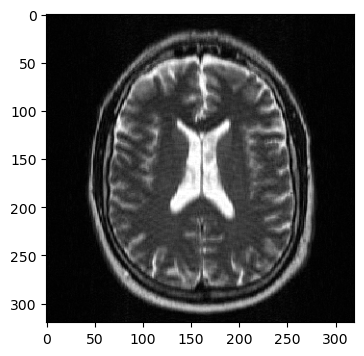

In [41]:
# Zero-filled solution
fx1 = np.zeros((N1*N2,1),dtype='cfloat') 
fx1[np.reshape(m,(N1*N2))] = data
fx1 = np.reshape(fx1,(N1,N2))
x1 = np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(fx1)))

plt.figure(figsize=(4,4))
imgplot = plt.imshow(abs(np.reshape(x1,(N1,N2))).T,cmap='gray',vmin=0,vmax=1)

f,g = evalGradients2(np.reshape(x1,(N1*N2,1)),[N1,N2],data,m,lam,D2,w)
la.norm(w)


Algorithm: Steepest Descent
Done
1410267906.502342


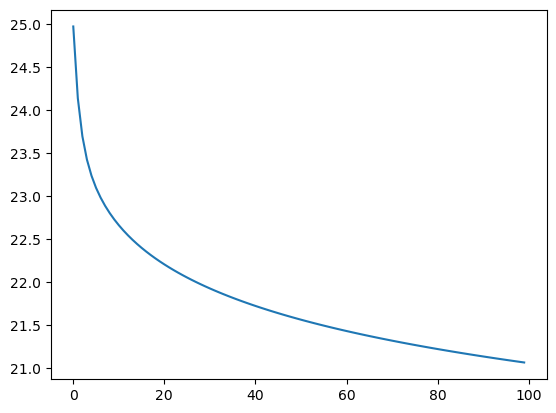

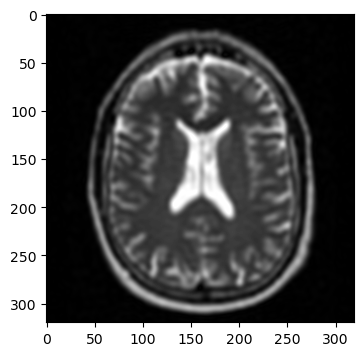

In [42]:
print('Algorithm: Steepest Descent')
if INIT_ZEROFILLED>0:
    x = x1
else:
    x = 0*x1

allfSD = np.zeros(niter)

x = np.reshape(x,(N1*N2,1))
for k in range(0,niter):
    f,g = evalGradients2(x,[N1,N2],data,m,lam,D2,w)
#    print(f)

    if la.norm(g)>0.000001:
        d = -g/np.max(abs(g)) # Normalizing gradient to get reasonable step size
        a0 = 0
        b0 = 1
        for kg in range(0,niterGS):
            a1 = x + d*a0 + d*(b0-a0)*0.382;
            b1 = x + d*a0 + d*(b0-a0)*0.618;
            fa1,temp1 = evalGradients2(a1,[N1,N2],data,m,lam,D2,w)
            fb1,temp1 = evalGradients2(b1,[N1,N2],data,m,lam,D2,w)
            if fb1<fa1:
                a0 = a0 + 0.382*(b0-a0);
            else:
                b0 = a0 + 0.618*(b0-a0);
                    
              
        alpha = (a0+b0)/2;
#        allx = np.concatenate((allx,x),axis=1)
        allfSD[k] = f
        x = x +alpha*d;

        
xSD = np.reshape(x,(N1,N2))        
        
print('Done')
print(f)
#print(x)
plt.plot(np.log(allfSD))

plt.figure(figsize=(4,4))
imgplot = plt.imshow(abs(xSD).T,cmap='gray',vmin=0,vmax=1)


Algorithm: Conjugate Gradients
Done
25895693.069428246


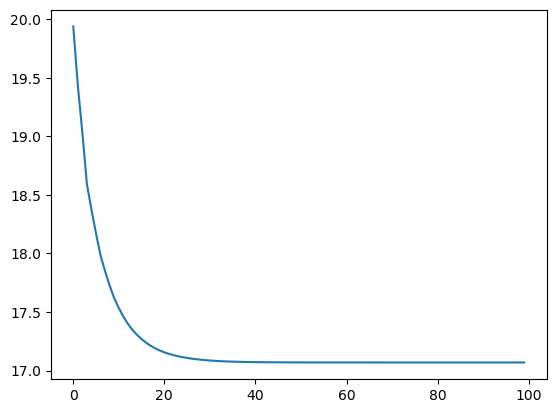

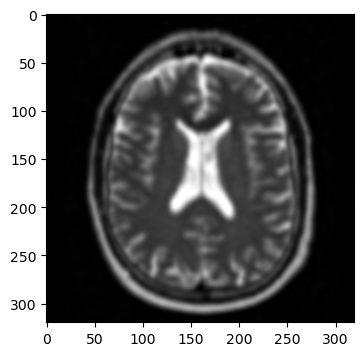

In [47]:
print('Algorithm: Conjugate Gradients')
if INIT_ZEROFILLED>0:
    x = x1
else:
    x = 0*x1

x = np.reshape(x,(N1*N2,1))
    
allfCG = np.zeros(niter)

f,g = evalGradients2(x,[N1,N2],data,m,lam,D2,w)
allfCG[0] = f 
if la.norm(g)>0.000001:
    d = -g
    k=1;
    while k < niter:
        fd = np.fft.fftshift(np.fft.fft2(np.fft.ifftshift(np.reshape(d,(N1,N2)))))
        fhfd = N1*N2*np.fft.fftshift(np.fft.ifft2(np.fft.ifftshift(np.reshape(m,(N1,N2))*np.reshape(fd,(N1,N2)))))
        temp = wvec*wvec*(D2.dot(np.reshape(d,(N1*N2,1))))
        Qd = np.reshape(fhfd,(N1*N2,1)) + lam*(D2.T).dot(temp)
        a = -((np.conj(g.T)).dot(d))/(np.conj(d.T).dot(Qd));
        x = x + a*d;
        f,g = evalGradients2(x,[N1,N2],data,m,lam,D2,w)
#        allx = np.concatenate((allx,x),axis=1)
        allfCG[k] = f
        if la.norm(g)>0.000001:
            b = (np.conj(g.T).dot(Qd))/(np.conj(d.T).dot(Qd));
            d = -g + b*d;
        else:
            k = niter
        k = k+1

xCG = np.reshape(x,(N1,N2))        
        
print('Done')
print(f)
#print(x)
plt.plot(np.log(allfCG))

plt.figure(figsize=(4,4))
imgplot = plt.imshow(abs(xCG).T,cmap='gray',vmin=0,vmax=1)

In [ ]:
max(np.)

100000000.0